In [1]:
# Import necessary libraries for this course ----------------------
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Download and load dataset ----------------------
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

# Set hyper-parameters ----------------------
mb_size = 64  # mini-batch size
Z_dim = 100  # latent-space dimension
X_dim = mnist.train.images.shape[1]
# y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3  # learning rate


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

In [0]:
# =============================== Q(z|X) ======================================

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))  # sample from unit gaussian
    return mu + torch.exp(log_var / 2) * eps  # re-parameterization trick

In [0]:

# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Iter-0; Loss: 763.1


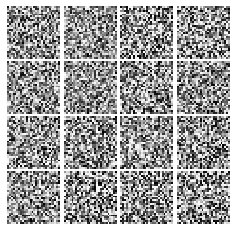

Iter-100; Loss: 225.4


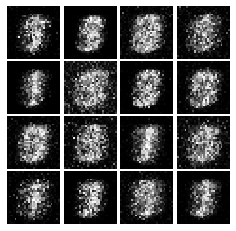

Iter-200; Loss: 188.2


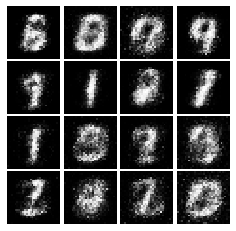

Iter-300; Loss: 172.1


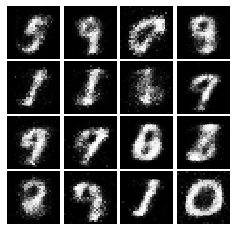

Iter-400; Loss: 171.7


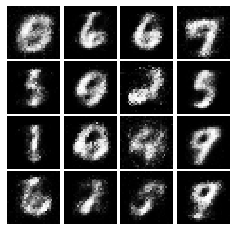

Iter-500; Loss: 165.0


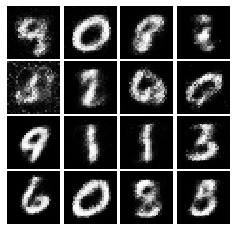

Iter-600; Loss: 154.8


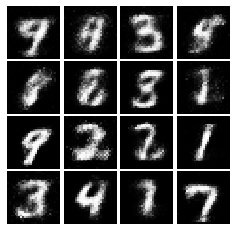

Iter-700; Loss: 158.5


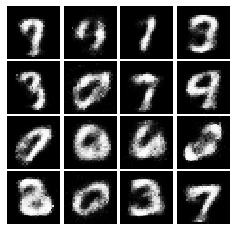

Iter-800; Loss: 143.4


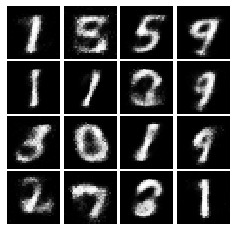

Iter-900; Loss: 146.0


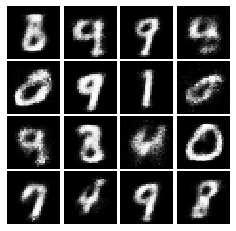

In [5]:
# =============================== TRAINING ====================================
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)  # Adam optimizer

for it in range(1000):
    X, _ = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))

    # Forward
    z_mu, z_var = Q(X)
    z = sample_z(z_mu, z_var)

    # Sampling from random z
    X_sample = P(z)

    # Loss
    # E[log P(X|z)]
    recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size

    # D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    # Backward
    loss.backward()

    # Update
    solver.step()

    # Housekeeping
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    # Print and plot every now and then
    if it % 100 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.item()))

        samples = P(z).data.numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')
        plt.show()
        plt.pause(0.1)
        # plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        # plt.close(fig)) || P(z)); calculate in closed form as both dist. are Gaussian